In [5]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2017-08-23 00:00:00
2016-08-23
            prcp
date            
2016-08-23  0.00
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15
2016-08-23  0.70
...          ...
2017-08-22  0.00
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2021 rows x 1 columns]


Text(0, 0.5, 'Precipitation')

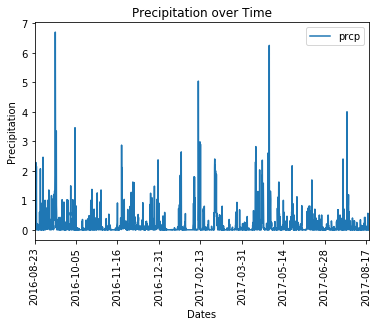

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

##HELP - Am I understanding this date query correctly?

# Calculate the date 1 year ago from the last data point in the database
latest_date_query = (session
                     .query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first()
                    )
print(latest_date_query)


latest_date = dt.datetime.strptime(latest_date_query[0], '%Y-%m-%d')
print(latest_date)

##Find one year in before the latest date found in the data
start_date_year_past = dt.date(latest_date.year -1, latest_date.month, latest_date.day)
print(start_date_year_past)
#print(f"The date range is {start_date_year_past} til {latest_date}")


# Perform a query to retrieve the data and precipitation scores
query_result = (session.query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date >= start_date_year_past)
                .all()
               )
#print(query_result)

precipitation = pd.DataFrame(query_result, columns=['date','prcp'])
#print(precipitation)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation.set_index("date", inplace=True)


# Sort the dataframe by date
precipitation = precipitation.sort_values(["date"], ascending=True)
precipitation = precipitation.dropna(how='any')
print(precipitation)

# Use Pandas Plotting with Matplotlib to plot the data
#Plot the results using the DataFrame plot method.

#Convert Precipitation to a numeric value in order to plot.
#precipitation
#precipitation["Precipitation"] = pd.to_numeric(precipitation["Precipitation"])


#y= precipitation["Precipitation"]
#x = precipitation.index
precipitation.plot(rot=90)
plt.title('Precipitation over Time')
plt.xlabel('Dates')
plt.ylabel('Precipitation')


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(Station.id).count()
count_stations

9

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.date)]
grouped_stations = (session.query(*sel)
                    .group_by(Measurement.station)
                    .order_by(func.count(Measurement.date).desc())
                    .all()
                   )
grouped_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

##HELP, confused which station id? Do I need to loop through each one?

# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

tobs_stations = (session.query(*sel)
                 .filter(Measurement.station =='USC00519281')
                    .order_by(Measurement.tobs)
                    .all()
                   )
print(tobs_stations)

[(54.0, 71.66378066378067, 85.0)]


Text(0, 0.5, 'Frequency')

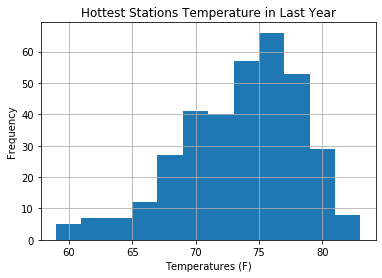

In [47]:
# Choose the station with the highest number of temperature observations.

#Completed in 2 cells above, variable is 'grouped_stations'.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.tobs]
max_temp_station = (session.query(*sel)
                    .filter(Measurement.station == 'USC00519281')
                    .filter(Measurement.date >= start_date_year_past)
                    .filter(Measurement.date <= latest_date)
                    .all()
                   )

    
#Create a histogram to plot this data.
df = pd.DataFrame(max_temp_station, columns=['Temperature'])
df.hist(bins=12)
plt.title('Hottest Stations Temperature in Last Year')
plt.xlabel('Temperatures (F)')
plt.ylabel('Frequency')



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
